## <span style = "color:blue">Causal Analysis in Settings where the control group is orders of magnitude larger than the treatment group </span>

In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
import numpy as np
import pandas as pd

#dowhy
import dowhy
from dowhy import CausalModel
import dowhy.datasets, dowhy.plotter

#econml-scikit-learn
import econml
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LassoCV
from sklearn.ensemble import GradientBoostingRegressor


#### Filter Out Unnecessary Warnings

In [3]:
import logging
logging.getLogger("dowhy").setLevel(logging.WARNING)
import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)


In [4]:
np.random.seed(seed = 0)


**For the clustering** we use as means $\mu_1, \mu_2$. We choose $w$ to be parallel in the line connecting the two means. <br> $\begin{align}w=\frac{\mu_2-\mu_1}{||\mu_2-\mu_1||}\end{align}$<br>
The bias $b$ can be adjusted such that the hyperplane passes through a point connecting the two means:<br>$
    \begin{align}
    b = \frac{(\mu_2-\mu_1)}{||\mu_2-\mu_1||}^T(\mu_1 + \lambda (\mu_2-\mu_1))
    \end{align}$

In [5]:
def generate_state(X, w = None, b = None, cluster = False):
    """
    Separates Patients
    with a linear hyperplane
    Patients above the hyperplane are healthy
    and below are sick
    
    
    """
    dims = X.shape[1]
    if not cluster:
        w = np.random.rand(dims, 1)
        w = w/np.sum(w)
        b = 1
        
    S = ((X@w-b) > 0).astype(int)
    
    return S


def generate_X(dims:int = 5, N:int = 10**4, cluster = False):
    
    """
    Generates X from a multidimension Normal distribution
    with the identity matrix for covariance
    
    """
    if not cluster:
        mu  = np.zeros(dims)
        loc = np.eye(dims)
        X = np.random.multivariate_normal(mean = mu, cov = loc, size = N)
        w = None
        b = None
        
    else:
        mu1 = np.zeros(dims)
        mu2 = np.ones(dims)
        loc = np.eye(dims)
        N1 = int(N*0.97)
        N2 = N-N1
        X1 = np.random.multivariate_normal(mean = mu1, cov = loc, size = N1)
        X2 = np.random.multivariate_normal(mean = mu2, cov = loc, size = N2)
        w = np.expand_dims((mu2-mu1)/np.sum(mu2-mu1), axis = 1)
        l = 0.85
        b = w.T@((1-l)*mu1[:,np.newaxis] + l*(mu2[:,np.newaxis]))
        X = np.concatenate((X1, X2), axis = 0)
        np.random.shuffle(X)
        print("{} people from cluster 1 generated".format(N1))
        print("{} people from cluster 2 generated".format(N2))

        
        
        
    return X, w, b

def treatment_assignment(S, M):
         """
         assign sick in treatment with p1
         assing healthy in treatment with p2
         S:State
         M:Number of people in treatment group
         """
         #generate a uniform sample 
         uniform = np.random.uniform(0,1,len(S))
         
         helper  = np.zeros_like(uniform)
         
         #assign healthy people to pseudo treatment
         #with probability 0.95
         helper[(uniform <= 0.98) & (S[:,0] == 1)] = 1
         
         #assign sick people to pseudo treatment
         #with probability 0.2
         helper[(uniform >= 0.95) & (S[:,0] == 0)]  = 1
         
         T = np.zeros_like(helper)
         index = np.where(helper == 1)[0]
         choose = np.random.choice(index, size = M, replace = False)
         
         #take a random sample of M from the pseudo treatment
         # and assign it to real treatment
         T[choose] = 1
         T =np.expand_dims(T, 1).astype(int)
         T  = np.where(T==1, True, False)
         return T
        
def make_experiment(dims, N, M, cluster = False):
    
    X, w, b = generate_X(dims, N, cluster = cluster)
    S = generate_state(X, w = w, b = b, cluster = cluster)
    T = treatment_assignment(S,M)
    
    print_stats(S,T)
    
    Yf, Ycf, Y = create_outcome(S,T)
    
    data = create_pandas(X, S, T, Yf, Ycf, Y)
    
    return X, S, T, data

def create_pandas(X, S, T, Yf, Ycf, Y):
    
    columns = ['f'+str(i) for i in range(X.shape[1])]
    columns.extend(['S', 'Tr', 'Yf', 'Ycf', 'Y'])
    
    data = pd.DataFrame(np.concatenate([X,S,T, Yf, Ycf, Y], axis = 1), columns = columns)
    return data
    
def print_stats(S,T):
    print("Population Size:", len(S))
    print("Sick Population Size:", (S==1).sum())
    print("Treatment group Size:", T.sum())
    print("Sick People in Treatment group:", ((S==1)&(T==1)).sum())

def create_outcome(S,T):
    
    Yf  = np.ones_like(S)
    Ycf = np.ones_like(S)
    Ycf[(S==1)] = 0
    Y = np.ones_like(S)
    Y[(S==1)&(T==0)] = 0
    
    return Yf, Ycf, Y

In [6]:
dims = 5
X, S, T, data= make_experiment(dims, 10**6, 1000, cluster=True)
data.Tr = data.Tr.astype(bool)

970000 people from cluster 1 generated
30000 people from cluster 2 generated
Population Size: 1000000
Sick Population Size: 46787
Treatment group Size: 1000
Sick People in Treatment group: 465


In [7]:
data.head()

,f0,f1,f2,f3,f4,S,Tr,Yf,Ycf,Y
0,0.900766,-0.040178,-1.083424,0.121346,-0.247905,0.0,False,1.0,1.0,1.0
1,0.178655,-0.498405,1.631524,1.267724,-0.245090,0.0,False,1.0,1.0,1.0
2,-1.532263,-1.673195,-0.825910,-2.163854,-1.181748,0.0,False,1.0,1.0,1.0
3,0.598833,-0.745410,0.673457,-0.178242,0.286164,0.0,False,1.0,1.0,1.0
4,1.044861,-1.624495,-1.035050,0.136189,0.205054,0.0,False,1.0,1.0,1.0


In [8]:
common_causes = ['f'+str(i) for i in range(dims)]
#common_causes.append('S')
data_dict = {'df':data,
             'treatment_name': 'Tr',
             'outcome_name': 'Y',
             'common_causes_names': common_causes,
             'time_val': None,
             'instrument_names': None,
             'dot_graph': None,
             'gml_graph': None,
             'ate': None}
             

In [9]:
model = CausalModel(
        data=data_dict['df'],
        treatment=data_dict["treatment_name"],
        outcome=data_dict["outcome_name"],
        common_causes=data_dict["common_causes_names"],
        )

In [10]:
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)


In [11]:
estimate = model.estimate_effect(identified_estimand,
                                 method_name="backdoor.propensity_score_stratification",
                                target_units='ate',
                                test_significance = None,
                                evaluate_effect_strength = False,
 confidence_intervals=False)
print(estimate)
print("Causal Estimate is " + str(estimate.value))

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate
### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                                 
─────(Expectation(Y|f3,f4,f0,f1,f2))
d[Tr]                               
Estimand assumption 1, Unconfoundedness: If U→{Tr} and U→Y then P(Y|Tr,f3,f4,f0,f1,f2,U) = P(Y|Tr,f3,f4,f0,f1,f2)
### Estimand : 2
Estimand name: iv
No such variable found!

## Realized estimand
b: Y~Tr+f3+f4+f0+f1+f2
Target units: ate

## Estimate
Mean value: 0.09541018707595271

Causal Estimate is 0.09541018707595271


In [12]:
data.Yf.mean() - data.Ycf.mean()

In [13]:
data[data.Tr==1].Y.mean() - data[data.Tr == 0].Y.mean()

In [14]:
data[(data.S==1) & (data.Tr ==1)].Y.mean() - data[(data.S==1) & (data.Tr ==0)].Y.mean()

In [15]:
data[(data.S==0) & (data.Tr ==1)].Y.mean() - data[(data.S==0) & (data.Tr ==0)].Y.mean()

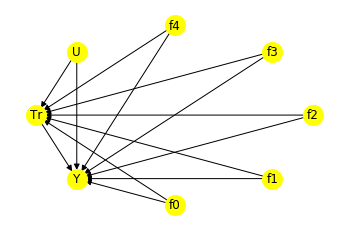

In [16]:
model.view_model()

In [17]:
data.head()

,f0,f1,f2,f3,f4,S,Tr,Yf,Ycf,Y,propensity_score,strata,dbar,d_y,dbar_y
0,0.900766,-0.040178,-1.083424,0.121346,-0.247905,0.0,False,1.0,1.0,1.0,0.000556,21.0,1,0.0,1.0
1,0.178655,-0.498405,1.631524,1.267724,-0.245090,0.0,False,1.0,1.0,1.0,0.001522,42.0,1,0.0,1.0
2,-1.532263,-1.673195,-0.825910,-2.163854,-1.181748,0.0,False,1.0,1.0,1.0,0.000049,0.0,1,0.0,1.0
3,0.598833,-0.745410,0.673457,-0.178242,0.286164,0.0,False,1.0,1.0,1.0,0.000833,31.0,1,0.0,1.0
4,1.044861,-1.624495,-1.035050,0.136189,0.205054,0.0,False,1.0,1.0,1.0,0.000429,15.0,1,0.0,1.0


## Using Econ ML


dml_estimate = model.estimate_effect(identified_estimand,
                                    method_name="backdoor.econml.dml.DMLCateEstimator",
                                    method_params={
                                        'init_params': {'model_y':GradientBoostingRegressor(),
                                                        'model_t': GradientBoostingRegressor(),
                                                        'model_final':LassoCV(fit_intercept=False), },
                                        'fit_params': {}
                                     })

dml_estimate.params['cate_estimates'].mean()

In [18]:
from sklearn.cluster import KMeans

In [19]:
kmeans = KMeans(n_clusters=2)
prediction = kmeans.fit_predict(data[common_causes].values)



In [20]:
cl1 = prediction == 1
data1 = data[cl1].reset_index(drop = True)
data2 = data[~cl1].reset_index(drop = True)

In [21]:
data1.describe()

,f0,f1,f2,f3,f4,S,Yf,Ycf,Y,propensity_score,strata,dbar,d_y,dbar_y
count,531616.000000,531616.000000,531616.000000,531616.000000,531616.000000,531616.0,531616.0,531616.0,531616.0,531616.000000,531616.000000,531616.000000,531616.000000,531616.000000
mean,-0.287588,-0.348828,-0.371957,-0.316373,-0.281822,0.0,1.0,1.0,1.0,0.000408,13.412177,0.999426,0.000574,0.999426
std,0.950336,0.926534,0.915637,0.939860,0.950877,0.0,0.0,0.0,0.0,0.000171,7.890180,0.023946,0.023946,0.023946
min,-4.895454,-4.852118,-4.802920,-4.820940,-5.031764,0.0,1.0,1.0,1.0,0.000013,0.000000,0.000000,0.000000,0.000000
25%,-0.927748,-0.971112,-0.986030,-0.947566,-0.922035,0.0,1.0,1.0,1.0,0.000272,7.000000,1.000000,0.000000,1.000000
50%,-0.284145,-0.343608,-0.365165,-0.313446,-0.279516,0.0,1.0,1.0,1.0,0.000401,13.000000,1.000000,0.000000,1.000000
75%,0.355717,0.277973,0.249408,0.319344,0.361252,0.0,1.0,1.0,1.0,0.000539,20.000000,1.000000,0.000000,1.000000
max,4.065940,3.783802,3.907693,3.831790,4.116536,0.0,1.0,1.0,1.0,0.001065,36.000000,1.000000,1.000000,1.000000


In [22]:
data1.Tr.sum(), ((data1.Tr == 1) & (data1.S==1)).sum()

(305, 0)

In [23]:
data2.Tr.sum(), ((data2.Tr == 1) & (data2.S==1)).sum()

(695, 465)

#### Modeling of 2 clusters 

In [24]:
data_dict1 = {'df':data1,
             'treatment_name': 'Tr',
             'outcome_name': 'Y',
             'common_causes_names': common_causes,
             'time_val': None,
             'instrument_names': None,
             'dot_graph': None,
             'gml_graph': None,
             'ate': None}

data_dict2 = {'df':data2,
             'treatment_name': 'Tr',
             'outcome_name': 'Y',
             'common_causes_names': common_causes,
             'time_val': None,
             'instrument_names': None,
             'dot_graph': None,
             'gml_graph': None,
             'ate': None}


model1 = CausalModel(
        data=data_dict1['df'],
        treatment=data_dict1["treatment_name"],
        outcome=data_dict1["outcome_name"],
        common_causes=data_dict1["common_causes_names"],
        )


model2 = CausalModel(
        data=data_dict2['df'],
        treatment=data_dict2["treatment_name"],
        outcome=data_dict2["outcome_name"],
        common_causes=data_dict2["common_causes_names"],
        )

identified_estimand1 = model1.identify_effect(proceed_when_unidentifiable=True)
identified_estimand2 = model2.identify_effect(proceed_when_unidentifiable=True)


In [25]:
estimate1 = model1.estimate_effect(identified_estimand1,
                                 method_name="backdoor.propensity_score_stratification",
                                target_units='ate',
                                test_significance = None,
                                evaluate_effect_strength = False,
 confidence_intervals=False)
print(estimate1)
print("Causal Estimate is " + str(estimate1.value))

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate
### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                                 
─────(Expectation(Y|f3,f4,f0,f1,f2))
d[Tr]                               
Estimand assumption 1, Unconfoundedness: If U→{Tr} and U→Y then P(Y|Tr,f3,f4,f0,f1,f2,U) = P(Y|Tr,f3,f4,f0,f1,f2)
### Estimand : 2
Estimand name: iv
No such variable found!

## Realized estimand
b: Y~Tr+f3+f4+f0+f1+f2
Target units: ate

## Estimate
Mean value: 0.0

Causal Estimate is 0.0


In [26]:
estimate2 = model2.estimate_effect(identified_estimand2,
                                 method_name="backdoor.propensity_score_stratification",
                                target_units='ate',
                                test_significance = None,
                                evaluate_effect_strength = False,
 confidence_intervals=False)
print(estimate2)
print("Causal Estimate is " + str(estimate2.value))

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate
### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                                 
─────(Expectation(Y|f3,f4,f0,f1,f2))
d[Tr]                               
Estimand assumption 1, Unconfoundedness: If U→{Tr} and U→Y then P(Y|Tr,f3,f4,f0,f1,f2,U) = P(Y|Tr,f3,f4,f0,f1,f2)
### Estimand : 2
Estimand name: iv
No such variable found!

## Realized estimand
b: Y~Tr+f3+f4+f0+f1+f2
Target units: ate

## Estimate
Mean value: 0.6641850953003251

Causal Estimate is 0.6641850953003251
